In [345]:
from collections import defaultdict
import gc
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils import save_pickle, load_pickle

In [397]:
class BlogDataset(Dataset):

    def __init__(self, x, y, vocab_size, cbow=False, max_len=None):
        """
        Parameters
        -----------
        x: pd.Series
            One of the outputs containing features from our 
            train_val_test_split().
        y: pd.DataFrame
            One of the outputs containing labels from our 
            train_val_test_split(). The first column contains gender 
            (0=female, 1=male) while the second column contains age.
        vocab_size: int
            Number of words in our vocabulary. We use w2idx for this, not 
            w2vec, since we may want to train embeddings for the words not
            in the GloVe vectors.
        cbow: bool
            If True, this assumes the dataset will be used with a CBOW model
            where word order doesn't matter. It will encode the x vector to 
            contain counts of word appearances in the sentence but will not
            retain anything about the temporal structure of the data. If 
            False, we return x as a vector of glove indices in the order the
            words appear in the sentence.
        """
        super().__init__()
        self.x = x
        self.y = y.values.astype(np.float32)
        self.cbow = cbow
        self.vocab_size = vocab_size
        self.max_len = max_len
        
    def __getitem__(self, i):
        """The CBOW model is just used as a simple baseline for gender 
        classification, so only the first column of y is needed in that case.
        """
        x, y = encode(self.x[i], w2idx, nlp), self.y[i]
        if self.cbow:
            x = count_encode(x, self.vocab_size)
            y = y[0]
        return x, y
    
    def __len__(self):
        if self.max_len:
            return self.max_len
        return self.x.shape[0]

In [398]:
def encode(text, w2idx, nlp):
    """Map each word in a post to its index in the embedding matrix. Posts
    retain their original lengths for now.
    """
    unk = w2idx['<UNK>']
    return [w2idx.get(word.text, unk) 
            for word in nlp(text, disable=['parser', 'tagger', 'ner'])]

In [399]:
def count_encode(idx_encoded, vocab_size):
    """Convert a vector of glove indices into a vector with the same length
    as our vocabulary. Each number will contain the count of the times that
    the corresponding word appeared in the original sentence. 
    
    Parameters
    -----------
    idx_encoded: np.ndarray
        Array of glove indices for a single sentence, with one number for each
        word.
    vocab_size: int
        Number of words in our vocabulary.
    """
    vec = np.zeros(vocab_size)
    for idx in idx_encoded:
        vec[idx] += 1
    return vec.astype(np.float32)

In [392]:
w2count = load_pickle('w2count')
w2idx = load_pickle('w2idx')
w2vec = load_pickle('w2vec')
i2w = load_pickle('i2w')
x_train, x_val, x_test, y_train, y_val, y_test = load_pickle('split_data')

x_train.shape, y_val.shape, x_test.shape

((7035676,), (35533, 2), (35535,))

In [393]:
bs = 64
workers = 2
ngpu = 1
lr = 3e-3
vocab_size = len(w2idx)
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')

In [42]:
nlp = spacy.load('en_core_web_sm')

## Models

In [154]:
class BaseModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [155]:
class GenderCBow(BaseModel):
    
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Training

In [321]:
def correct(y_hat, y, reduction, sigmoid=True):
    """Calculate the accuracy if reduction='mean' or the total correct if 
    reduction='sum'.
    
    y_hat: torch.tensor
        2D tensor of predictions.
    y: torch.tensor
        2D tensor of labels.
    reduction: str
        'sum' or 'mean'
    sigmoid: bool
        If True, apply sigmoid before calculating number correct.
    """
    with torch.no_grad():
        if sigmoid:
            y_hat = torch.sigmoid(y_hat)
        correct = torch.round(y_hat).eq(y).float()
        if reduction == 'sum':
            return torch.sum(correct).item()
        elif reduction == 'mean':
            return torch.mean(correct).item()

In [332]:
def val_metrics(model, val_dl):
    """Return validation loss and accuracy."""
    stats = defaultdict(int)
    with torch.no_grad():
        for x, y in val_dl:
            x = x.to(device)
            y = y.unsqueeze(-1).to(device)
            batch_size = x.shape[0]
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y, 
                                                      reduction='sum')
            
            # Update stats at end of batch.
            stats['loss'] += loss
            stats['total'] += batch_size
            stats['correct'] += correct(y_hat, y, 'sum', sigmoid=True)

    return stats['loss'] / stats['total'], stats['correct'] / stats['total']

In [430]:
def train(epochs, train_dl, val_dl, lr=3e-3, model=None, optim=None, dim=100):
    """Train with Adam optimizer."""
    if not model:
        model = GenderCBow(vocab_size, dim)
        optim = torch.optim.Adam(model.parameters(), lr)
    
    # Store stats to return at end.
    stats = defaultdict(list)
    
    # Begin training loop.
    for epoch in range(epochs):
        e_stats = defaultdict(int)
        model.train()
        
        # Loop through mini batches.
        for i, (x, y) in enumerate(train_dl, 1):
            x = x.to(device)
            y = y.unsqueeze(-1).to(device)
            batch_size = x.shape[0]
            
            # Forward and backward pass.
            optim.zero_grad()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y, 
                                                      reduction='mean')
            loss.backward()
            optim.step()
            
            # Update stats at end of batch.
            e_stats['train_loss'] += loss.item() * batch_size
            e_stats['total'] += batch_size
            e_stats['correct'] += correct(y_hat, y, reduction='sum')
            
            if i % 100 == 0:
                print(f'loss (mini batch {i}): {(loss / batch_size):.3f}')
            
        # Update stats at end of epoch.
        e_stats['val_loss'], e_stats['val_acc'] = val_metrics(model, val_dl)
        e_stats['train_acc'] = e_stats['correct'] / e_stats['total']
        e_stats['train_loss'] = e_stats['train_loss'] / e_stats['total']
        
        # Update stats at end of epoch.   
        for key in ('train_loss', 'train_acc', 'val_loss', 'val_acc'):
            stats[key].append(e_stats[key])

        print(f"\nEpoch [{epoch+1}/{epochs}]"
              f"\nTrain loss: {e_stats['train_loss']:.3f}"
              f"\tTrain acc: {e_stats['train_acc']:.3f}"
              f"\nValidation loss: {e_stats['val_loss']:.3f}"
              f"\tValidation acc: {e_stats['val_acc']:.3f}"
             )

    return dict(model=model, optim=optim, stats=stats)

In [431]:
def plot_output(output):
    """Plot loss by epoch for train and validation sets. Parameters should be 
    returned by the training loop.
    
    Parameters
    -----------
    output: dict
        Dict returned by train(). Contains defaultdict with stats.
    """
    stats = output['stats']
    fig, ax = plt.subplots()
    ax.plot(stats['train_loss'], label='train')
    ax.plot(stats['val_loss'], label='validation')
    plt.xlim(0, len(stats['train_loss'])-1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss by Epoch')
    plt.show()

In [432]:
ds_train = BlogDataset(x_train, y_train, len(w2idx), cbow=True, 
                       max_len=100_000)
ds_val = BlogDataset(x_val, y_val, len(w2idx), cbow=True, max_len=5_000)

In [433]:
train_dl = DataLoader(ds_train, batch_size=bs, shuffle=True, 
                      num_workers=workers)
val_dl = DataLoader(ds_val, batch_size=bs, shuffle=False, num_workers=workers)

In [434]:
x1, y1 = next(iter(train_dl))
x1.shape, y1.shape

(torch.Size([64, 193800]), torch.Size([64]))

In [435]:
len(train_dl)

1563

In [436]:
epochs = 10
output = train(epochs, train_dl, val_dl)

loss (mini batch 100): 0.011
loss (mini batch 200): 0.011
loss (mini batch 300): 0.010
loss (mini batch 400): 0.010
loss (mini batch 500): 0.010
loss (mini batch 600): 0.011
loss (mini batch 700): 0.010
loss (mini batch 800): 0.011
loss (mini batch 900): 0.010
loss (mini batch 1000): 0.011
loss (mini batch 1100): 0.011
loss (mini batch 1200): 0.010
loss (mini batch 1300): 0.010
loss (mini batch 1400): 0.010
loss (mini batch 1500): 0.010

Epoch [1/10]
Train loss: 0.671	Train acc: 0.584
Validation loss: 0.670	Validation acc: 0.589
loss (mini batch 100): 0.009
loss (mini batch 200): 0.009
loss (mini batch 300): 0.010
loss (mini batch 400): 0.009
loss (mini batch 500): 0.009
loss (mini batch 600): 0.009
loss (mini batch 700): 0.010
loss (mini batch 800): 0.008
loss (mini batch 900): 0.010
loss (mini batch 1000): 0.010
loss (mini batch 1100): 0.009
loss (mini batch 1200): 0.008
loss (mini batch 1300): 0.009
loss (mini batch 1400): 0.009
loss (mini batch 1500): 0.009

Epoch [2/10]
Train loss

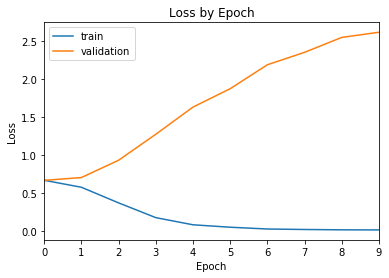

In [437]:
plot_output(output)

In [404]:
output_2 = train(10, train_dl, val_dl, dim=10)

KeyboardInterrupt: 

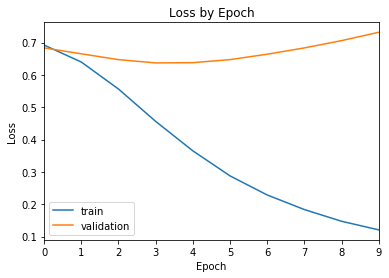

In [369]:
plot_output(output_2)

I started by fitting a simple count-based variation of the continuous bag of words model, which discards the temporal nature of the data. I will not use any tricks, add any dropout or batch norm layers, or spend much time tuning hyperparameters here as the goal is not to optimize performance. I simply want to get a quick baseline of how well a basic model does on the problem. To reduce training time, I also started with a small subset of the data and slowly increased it to see if this would help with overfitting.